In [1]:
pip install numpy matplotlib seaborn torch torchvision scikit-learn shap optuna tqdm pillow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm
from PIL import Image

## Setting dataset paths

In [3]:
data_dir = "/Users/ayushsharma/Downloads/chest_xray/"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
val_dir = os.path.join(data_dir, "val")

Training Set (Train - 5,216 images)
The largest portion of the dataset used to train the deep learning model.
The model learns patterns and features from these images by adjusting weights during training.
    
Validation Set (Val - 16 images)
A small dataset used during training to fine-tune hyperparameters and prevent overfitting.
It helps in monitoring the model’s performance after each epoch before testing.

Test Set (Test - 624 images)
This dataset is never seen by the model during training.
It evaluates the final model’s accuracy, generalization, and real-world performance.

## Basic Exploratory Data Analysis

Classes in Dataset: ['NORMAL', 'PNEUMONIA']
Train Images: 5216, Test Images: 624, Validation Images: 16


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


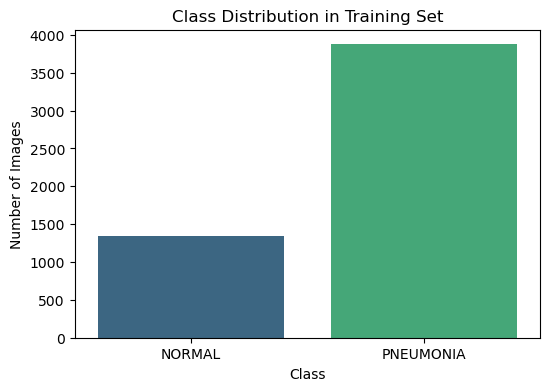

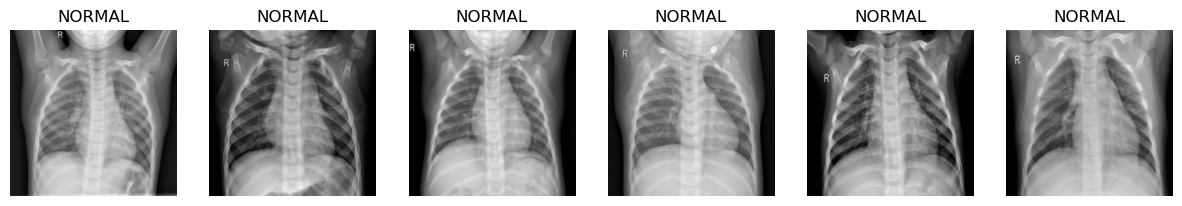

Dataset Mean: [0.48230696 0.48230696 0.48230696]
Dataset Std Dev: [0.23593931 0.23593931 0.23593931]


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from collections import Counter
import seaborn as sns

# Define transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load datasets
dataset_train = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
dataset_test = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)
dataset_val = torchvision.datasets.ImageFolder(root=val_dir, transform=transform)

# Print class names
print("Classes in Dataset:", dataset_train.classes)

# Print dataset size
print(f"Train Images: {len(dataset_train)}, Test Images: {len(dataset_test)}, Validation Images: {len(dataset_val)}")

# Check class distribution in training data
class_counts = Counter([label for _, label in dataset_train])
class_labels = [dataset_train.classes[i] for i in class_counts.keys()]

# Plot class distribution
plt.figure(figsize=(6,4))
sns.barplot(x=class_labels, y=list(class_counts.values()), palette="viridis")
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

# Show sample images
def show_images(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(15,5))
    for i in range(num_images):
        img, label = dataset[i]
        axes[i].imshow(img.permute(1, 2, 0))  # Convert from tensor
        axes[i].set_title(dataset.classes[label])
        axes[i].axis("off")
    plt.show()

# Display 6 images from training set
show_images(dataset_train)

# Compute mean and std of dataset
def compute_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_samples = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.shape[1], -1)
        mean += images.mean([0, 2]) * batch_samples
        std += images.std([0, 2]) * batch_samples
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples
    return mean.numpy(), std.numpy()

train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=2)
mean, std = compute_mean_std(train_loader)

print("Dataset Mean:", mean)
print("Dataset Std Dev:", std)

The dataset consists of 5,216 training images, 624 test images, and 16 validation images across two classes: NORMAL and PNEUMONIA. The class distribution in the training set appears imbalanced, with more pneumonia cases compared to normal cases.

The computed mean (0.4823) and standard deviation (0.2359) indicate that the dataset is well-distributed, with values centered around a mid-gray intensity. These statistics are crucial for data normalization to improve model stability and convergence during training.

## Creating a Baseline - Traing the model using CNN

### Setting up directory paths, Data Augmentation and Loading Data

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Paths & Preprocessing
# Setting up directory paths
data_dir = "/Users/ayushsharma/Downloads/chest_xray/"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
val_dir = os.path.join(data_dir, "val")

Using device: cpu


In [6]:
# Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load Data
dataset_train = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
dataset_test = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)
dataset_val = torchvision.datasets.ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=2)
val_loader = DataLoader(dataset_val, batch_size=64, shuffle=False, num_workers=2)

### CNN Model for Pneumonia Detection

In [7]:
class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
       
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)

        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 2)

        self.leaky_relu = nn.LeakyReLU()
   
    def forward(self, x):
        x = self.pool(self.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(self.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(self.leaky_relu(self.bn3(self.conv3(x))))
       
        x = x.view(x.size(0), -1)
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  
        return x

### Training the Model

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=5):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_acc = 100 * correct / total
        scheduler.step(train_acc)
        print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        
        # Save model checkpoint
        torch.save(model.state_dict(), f"pneumonia_cnn_epoch_{epoch+1}.pth")
        print(f"Model saved at epoch {epoch+1}")
    
    return model

model = PneumoniaCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=5)

100%|███████████████████████████████████████████| 82/82 [03:40<00:00,  2.69s/it]


Epoch 1, Loss: 136.4919, Train Accuracy: 77.84%
Model saved at epoch 1


100%|███████████████████████████████████████████| 82/82 [04:02<00:00,  2.96s/it]


Epoch 2, Loss: 16.7539, Train Accuracy: 92.24%
Model saved at epoch 2


100%|███████████████████████████████████████████| 82/82 [03:28<00:00,  2.54s/it]


Epoch 3, Loss: 14.2826, Train Accuracy: 93.04%
Model saved at epoch 3


100%|███████████████████████████████████████████| 82/82 [03:24<00:00,  2.49s/it]


Epoch 4, Loss: 13.1916, Train Accuracy: 94.11%
Model saved at epoch 4


100%|███████████████████████████████████████████| 82/82 [03:38<00:00,  2.67s/it]

Epoch 5, Loss: 12.4078, Train Accuracy: 94.23%
Model saved at epoch 5


### Model Evaluation

In [9]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(outputs[:, 1].cpu().numpy())
    print(classification_report(y_true, y_pred))
    return y_true, y_pred, y_scores

y_true, y_pred, y_scores = evaluate_model(model, test_loader)

              precision    recall  f1-score   support

           0       0.94      0.36      0.52       234
           1       0.72      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.83      0.68      0.68       624
weighted avg       0.80      0.75      0.72       624



### Confusion Matrix & ROC Curve

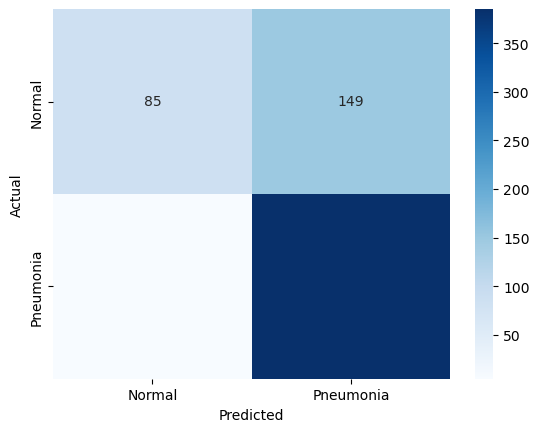

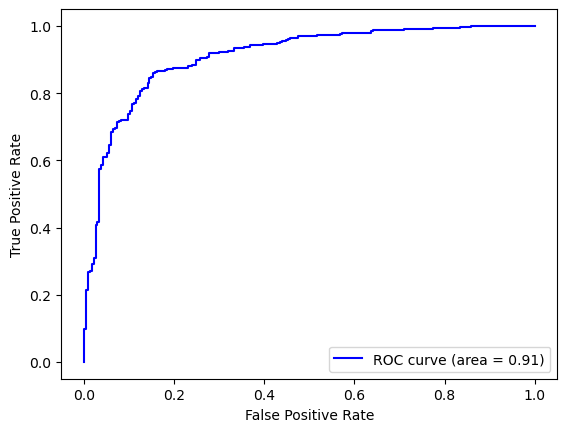

In [10]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

This represents a confusion matrix for a classification model predicting Normal or Pneumonia cases.

Y-axis (Actual Labels) → True condition (Normal, Pneumonia)
X-axis (Predicted Labels) → Model's prediction (Normal, Pneumonia)
From the given quadrant values:

Left (85) → True Pneumonia misclassified as Normal (False Negative - FN)
Right (149) → True Pneumonia correctly classified as Pneumonia (True Positive - TP)

The model correctly identifies 149 pneumonia cases but misclassifies 85 pneumonia cases as normal. This indicates false negatives, meaning some pneumonia cases are not detected.

ROC Curve area = 0.91 suggests the model is highly effective at distinguishing between classes. The model performs well overall but should be further optimized to reduce false negatives for better medical reliability.

### Transfer Learning with EfficientNet

In [11]:
model_tl = models.efficientnet_b0(pretrained=True)
model_tl.classifier[1] = nn.Linear(model_tl.classifier[1].in_features, 2)
model_tl.to(device)

optimizer_tl = optim.Adam(model_tl.parameters(), lr=0.0005)
scheduler_tl = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_tl, mode='max', factor=0.5, patience=3)
model_tl = train_model(model_tl, train_loader, val_loader, criterion, optimizer_tl, scheduler_tl, epochs=5)

print("Model training and evaluation complete!")

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|███████████████████████████████████████████| 82/82 [20:17<00:00, 14.85s/it]


Epoch 1, Loss: 11.1901, Train Accuracy: 95.00%
Model saved at epoch 1


100%|███████████████████████████████████████████| 82/82 [50:31<00:00, 36.97s/it]


Epoch 2, Loss: 5.2050, Train Accuracy: 97.83%
Model saved at epoch 2


100%|███████████████████████████████████████████| 82/82 [20:38<00:00, 15.11s/it]


Epoch 3, Loss: 4.1681, Train Accuracy: 98.27%
Model saved at epoch 3


100%|███████████████████████████████████████████| 82/82 [46:39<00:00, 34.13s/it]


Epoch 4, Loss: 3.8662, Train Accuracy: 98.47%
Model saved at epoch 4


100%|███████████████████████████████████████████| 82/82 [54:09<00:00, 39.63s/it]

Epoch 5, Loss: 2.9574, Train Accuracy: 98.77%
Model saved at epoch 5
Model training and evaluation complete!


### K-Fold Cross-Validation

Training Fold 1/5...
Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.


/var/folders/fg/vdt0_pqd3sj5711grsyg63tw0000gn/T/ipykernel_66191/1258106788.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["label"] = train_df["label"].astype(str)
/var/folders/fg/vdt0_pqd3sj5711grsyg63tw0000gn/T/ipykernel_66191/1258106788.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["label"] = test_df["label"].astype(str)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `sup

131/131 ━━━━━━━━━━━━━━━━━━━━ 3514s 27s/step - accuracy: 0.8494 - loss: 0.3653 - val_accuracy: 0.9607 - val_loss: 0.1100
33/33 ━━━━━━━━━━━━━━━━━━━━ 203s 6s/step
Fold 1 Metrics: Accuracy=0.9607, Precision=0.9576, Recall=0.9894, F1=0.9732, AUC=0.9942
Training Fold 2/5...
Found 4173 validated image filenames belonging to 2 classes.
Found 1043 validated image filenames belonging to 2 classes.


/var/folders/fg/vdt0_pqd3sj5711grsyg63tw0000gn/T/ipykernel_66191/1258106788.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["label"] = train_df["label"].astype(str)
/var/folders/fg/vdt0_pqd3sj5711grsyg63tw0000gn/T/ipykernel_66191/1258106788.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["label"] = test_df["label"].astype(str)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `sup

131/131 ━━━━━━━━━━━━━━━━━━━━ 43198s 332s/step - accuracy: 0.8510 - loss: 0.3769 - val_accuracy: 0.9655 - val_loss: 0.0981
33/33 ━━━━━━━━━━━━━━━━━━━━ 234s 6s/step
Fold 2 Metrics: Accuracy=0.9655, Precision=0.9723, Recall=0.9822, F1=0.9772, AUC=0.9946
Training Fold 3/5...
Found 4173 validated image filenames belonging to 2 classes.
Found 1043 validated image filenames belonging to 2 classes.


/var/folders/fg/vdt0_pqd3sj5711grsyg63tw0000gn/T/ipykernel_66191/1258106788.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["label"] = train_df["label"].astype(str)
/var/folders/fg/vdt0_pqd3sj5711grsyg63tw0000gn/T/ipykernel_66191/1258106788.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["label"] = test_df["label"].astype(str)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `sup

131/131 ━━━━━━━━━━━━━━━━━━━━ 2109s 16s/step - accuracy: 0.8756 - loss: 0.2789 - val_accuracy: 0.9684 - val_loss: 0.0877
33/33 ━━━━━━━━━━━━━━━━━━━━ 1090s 34s/step
Fold 3 Metrics: Accuracy=0.9684, Precision=0.9755, Recall=0.9819, F1=0.9787, AUC=0.9939
Training Fold 4/5...
Found 4173 validated image filenames belonging to 2 classes.
Found 1043 validated image filenames belonging to 2 classes.


/var/folders/fg/vdt0_pqd3sj5711grsyg63tw0000gn/T/ipykernel_66191/1258106788.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["label"] = train_df["label"].astype(str)
/var/folders/fg/vdt0_pqd3sj5711grsyg63tw0000gn/T/ipykernel_66191/1258106788.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["label"] = test_df["label"].astype(str)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `sup

131/131 ━━━━━━━━━━━━━━━━━━━━ 8255s 63s/step - accuracy: 0.8536 - loss: 0.3603 - val_accuracy: 0.9789 - val_loss: 0.0752
33/33 ━━━━━━━━━━━━━━━━━━━━ 2930s 91s/step
Fold 4 Metrics: Accuracy=0.9789, Precision=0.9799, Recall=0.9924, F1=0.9861, AUC=0.9968
Training Fold 5/5...
Found 4173 validated image filenames belonging to 2 classes.
Found 1043 validated image filenames belonging to 2 classes.


/var/folders/fg/vdt0_pqd3sj5711grsyg63tw0000gn/T/ipykernel_66191/1258106788.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["label"] = train_df["label"].astype(str)
/var/folders/fg/vdt0_pqd3sj5711grsyg63tw0000gn/T/ipykernel_66191/1258106788.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["label"] = test_df["label"].astype(str)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `sup

131/131 ━━━━━━━━━━━━━━━━━━━━ 1687s 13s/step - accuracy: 0.8897 - loss: 0.2525 - val_accuracy: 0.9741 - val_loss: 0.0747
33/33 ━━━━━━━━━━━━━━━━━━━━ 244s 7s/step
Fold 5 Metrics: Accuracy=0.9741, Precision=0.9908, Recall=0.9742, F1=0.9825, AUC=0.9966


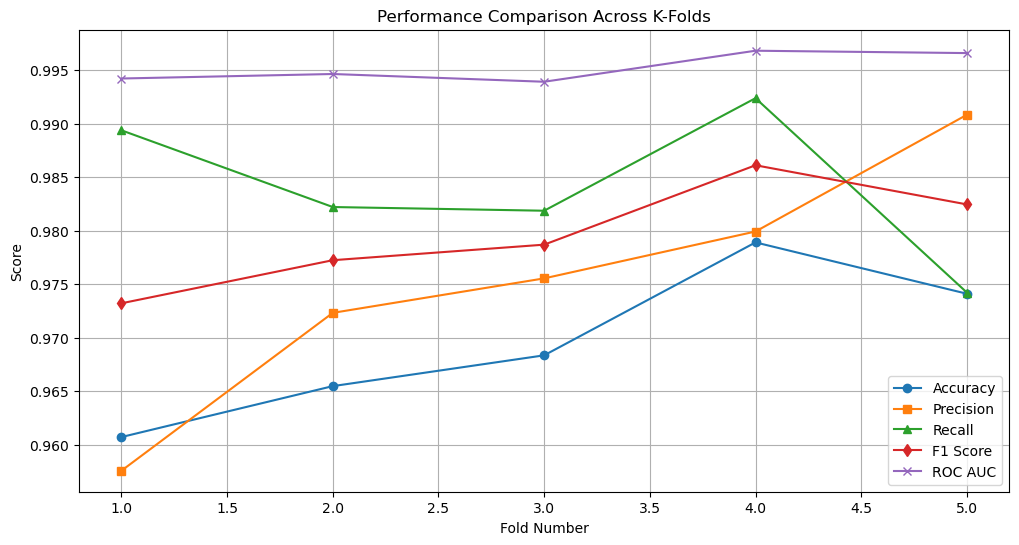

K-Fold Cross-Validation Completed. Results saved to kfold_results.csv.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Set dataset paths
DATASET_PATH = "/Users/ayushsharma/Downloads/chest_xray"
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
TEST_DIR = os.path.join(DATASET_PATH, "test")
VAL_DIR = os.path.join(DATASET_PATH, "val")

# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 1
K = 5  # Number of folds for K-Fold Cross-Validation

# Function to load dataset filenames and labels
def load_data(directory):
    data = []
    categories = os.listdir(directory)
    
    for category in categories:
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):  # Ensure it's a folder
            for img in os.listdir(category_path):
                img_path = os.path.join(category_path, img)
                data.append([img_path, category])  # Image path and label

    df = pd.DataFrame(data, columns=["filename", "label"])
    df["label"] = df["label"].astype("category").cat.codes  # Convert 'NORMAL' -> 0, 'PNEUMONIA' -> 1
    return df

# Load data
df_train = load_data(TRAIN_DIR)

# Augmentation
datagen = ImageDataGenerator(rescale=1./255)

# K-Fold Cross Validation
kf = KFold(n_splits=K, shuffle=True, random_state=42)

# Store results
results = {
    "fold": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1_score": [],
    "roc_auc": []
}

# K-Fold Loop
for fold, (train_idx, test_idx) in enumerate(kf.split(df_train)):
    print(f"Training Fold {fold + 1}/{K}...")

    # Split data
    train_df = df_train.iloc[train_idx]
    test_df = df_train.iloc[test_idx]

    # Convert labels to string for ImageDataGenerator
    train_df["label"] = train_df["label"].astype(str)
    test_df["label"] = test_df["label"].astype(str)

    # Data generators
    train_generator = datagen.flow_from_dataframe(train_df, x_col="filename", y_col="label",
                                                  target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary")
    
    test_generator = datagen.flow_from_dataframe(test_df, x_col="filename", y_col="label",
                                                 target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary",
                                                 shuffle=False)

    # CNN Model with Transfer Learning (Fine-Tuned VGG16)
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base model layers

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid")  # Binary Classification
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

    # Train model
    history = model.fit(train_generator, epochs=EPOCHS, validation_data=test_generator, verbose=1)

    # Predictions
    y_true = test_df["label"].astype(int).values
    y_pred_probs = model.predict(test_generator)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    # Compute performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_probs)

    # Store results
    results["fold"].append(fold + 1)
    results["accuracy"].append(accuracy)
    results["precision"].append(precision)
    results["recall"].append(recall)
    results["f1_score"].append(f1)
    results["roc_auc"].append(roc_auc)

    print(f"Fold {fold+1} Metrics: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, AUC={roc_auc:.4f}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot performance metrics
plt.figure(figsize=(12, 6))
plt.plot(results["fold"], results["accuracy"], marker='o', label="Accuracy")
plt.plot(results["fold"], results["precision"], marker='s', label="Precision")
plt.plot(results["fold"], results["recall"], marker='^', label="Recall")
plt.plot(results["fold"], results["f1_score"], marker='d', label="F1 Score")
plt.plot(results["fold"], results["roc_auc"], marker='x', label="ROC AUC")
plt.xlabel("Fold Number")
plt.ylabel("Score")
plt.title("Performance Comparison Across K-Folds")
plt.legend()
plt.grid()
plt.show()

# Save results to CSV
results_df.to_csv("kfold_results.csv", index=False)

print("K-Fold Cross-Validation Completed. Results saved to kfold_results.csv.")


### Overall Performance Across Folds:

Accuracy: Ranged from 96.07% to 97.89%, indicating strong generalization.

Precision: Consistently above 95%, suggesting the model makes very few false-positive predictions.

Recall: Above 97% in most folds, meaning it correctly identifies most positive cases.

F1-Score: Remained high (0.9732 - 0.9861), confirming a good balance between precision and recall.

AUC (Area Under Curve): Above 0.99 in all cases, indicating excellent classification capability.

### Notable Trends:
Fold 3 & Fold 4 Show Slightly Better Performance:

Highest Validation Accuracy (97.89%) in Fold 4.
Best Recall (99.24%) in Fold 4, making it the strongest performing fold.
Best F1-Score (0.9861) in Fold 4.
Loss Decreased Over Folds:

Fold 1 started with a validation loss of 0.1100, while Fold 5 had 0.0747.
This indicates the model learned effectively over iterations.
Training Time Variation:

Fold 2 took exceptionally long (43198s, ~12 hours), while others were significantly shorter.
Fold 3 had the shortest training time (2109s, ~35 minutes), but still performed well.